In [5]:
from __future__ import annotations

In [6]:
from IPython.display import display, HTML
display(HTML('<style>.container { width:100% !important; }</style>'))

In [14]:

import os
import pydot
import datetime
import numpy as np
import sklearn.metrics
import tensorflow as tf
import sklearn.datasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import seaborn as sns
sns.set_style('dark')
sns.set(rc={'figure.figsize': (10, 10), 'axes.grid': False})

In [15]:
rng = np.random.default_rng()

In [16]:
gpus = tf.config.list_physical_devices('GPU')
print(gpus)
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print('GPU enable')
    except:
        print('GPU not enable')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU enable


In [17]:
def plot_grid(X, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    imgs = X[rng.choice(np.arange(X.shape[0]), size=ax.shape)].reshape(*ax.shape, 28, 28)
    for i in range(ax.shape[0]):
        for j in range(ax.shape[1]):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            if hide_axes:
                ax[i, j].get_xaxis().set_visible(False)
                ax[i, j].get_yaxis().set_visible(False)

In [18]:
def plot_grid_and_label(X, y, model, ncols=2, nrows=2, figsize=(10, 10), hide_axes=True, flatten_image=True, label_description=None):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=figsize)
    idx = rng.choice(np.arange(X.shape[0]), size=ax.shape)
    imgs, labels = X[idx], y[idx]
    inputs = imgs.reshape(-1, *imgs.shape[2:])

    if flatten_image:
        inputs = inputs.reshape(nrows * ncols, -1)

    if label_description is None:
        map_label = lambda x: x
    else:
        map_label = lambda x: label_description[x] if isinstance(label_description, dict) else label_description[x]

    preds = np.argmax(tf.nn.softmax(model.predict(inputs)), axis=-1).reshape(nrows, ncols)
    for i in range(nrows):
        for j in range(ncols):
            ax[i, j].imshow(imgs[i, j], cmap='gray')
            ax[i, j].set_title(f"label: {map_label(labels[i, j])}, prediction: {map_label(preds[i, j])}")
            if hide_axes:
                ax[i, j].axis("off")


In [19]:
label_description = [
     'A',   'I',   'U',  'E',  'O',
    'KA',  'KI',  'KU', 'KE', 'KO',
    'SA', 'SHI',  'SU', 'SE', 'SO',
    'TA', 'CHI', 'TSU', 'TE', 'TO',
    'NA',  'NI',  'NU', 'NE', 'NO',
    'HA',  'HI',  'FU', 'HE', 'HO',
    'MA',  'MI',  'MU', 'ME', 'MO',
    'YA',         'YU',       'YO',
    'RA',  'RI',  'RU', 'RE', 'RO',
    'WA',  'II',        'EE', 'WO',
     'N',  'IT'
]

In [20]:
X, y = sklearn.datasets.fetch_openml('Kuzushiji-49', version=1, return_X_y=True, as_frame=False)
y = np.array(list(map(int, y)))
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [21]:
counts = { j: np.sum(y_train == i) for i, j in enumerate(label_description) }

In [22]:
counts # what to do with imbalanced classes?

{'A': 5227,
 'I': 5251,
 'U': 5236,
 'E': 670,
 'O': 5266,
 'KA': 5251,
 'KI': 5256,
 'KU': 5210,
 'KE': 4139,
 'KO': 5304,
 'SA': 5266,
 'SHI': 5207,
 'SU': 5212,
 'SE': 3633,
 'SO': 3299,
 'TA': 5289,
 'CHI': 2226,
 'TSU': 5223,
 'TE': 5257,
 'TO': 5224,
 'NA': 5273,
 'NI': 5335,
 'NU': 1799,
 'NE': 2149,
 'NO': 5341,
 'HA': 5235,
 'HI': 4506,
 'FU': 5201,
 'HE': 5269,
 'HO': 1715,
 'MA': 5272,
 'MI': 2692,
 'MU': 1495,
 'ME': 2966,
 'MO': 5252,
 'YA': 5217,
 'YU': 1398,
 'YO': 5257,
 'RA': 5246,
 'RI': 5216,
 'RU': 5289,
 'RE': 5229,
 'RO': 1871,
 'WA': 2104,
 'II': 367,
 'EE': 343,
 'WO': 5263,
 'N': 5160,
 'IT': 3078}

In [23]:
counter = 0
for key, value in counts.items():
    counter += value
counter /= 49

In [24]:
class_weights = {}
i = 0
for _, value in counts.items():
    class_weights[i] = (counter / value)
    i += 1


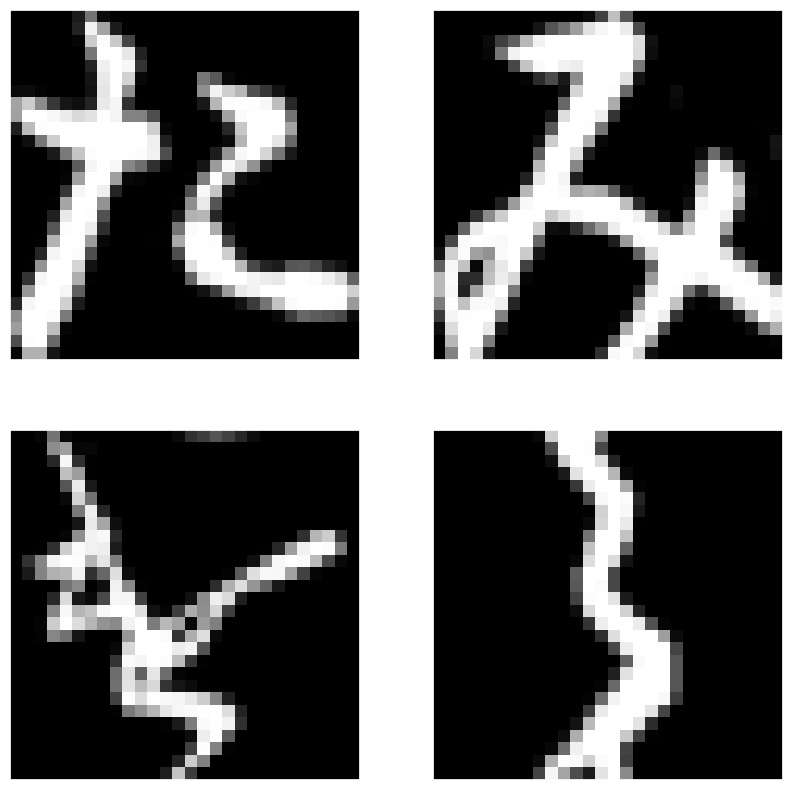

In [25]:
plot_grid(X_train)

## Flattened images
Use Dense layers

In [26]:
# create train and validation datasets, these datasets should use flattened images

In [27]:
train_data = tf.data.Dataset.from_tensor_slices(X_train).map(lambda x: tf.cast(x / 255, tf.float32))
train_labels = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_data, train_labels)).batch(32)

val_data = tf.data.Dataset.from_tensor_slices(X_test).map(lambda x: tf.cast(x / 255, tf.float32))
val_labels = tf.data.Dataset.from_tensor_slices(y_test)
val_dataset = tf.data.Dataset.zip((val_data, val_labels)).batch(32)

In [ ]:
# create model, this model should accept a flattened image

In [28]:
inputs = tf.keras.layers.Input((784,), name='input')
x = tf.keras.layers.Dense(512, activation='relu', name='dense1')(inputs)
x = tf.keras.layers.Dense(256, activation='relu', name='dense2')(x)
x = tf.keras.layers.Dense(128, activation='relu', name='dense3')(x)
x = tf.keras.layers.Dense(49, activation='softmax', name='output')(x)
model = tf.keras.Model(inputs=inputs, outputs=x, name='kuzuzuzu49')

In [29]:
model.summary()

Model: "kuzuzuzu49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 784)]             0         
                                                                 
 dense1 (Dense)              (None, 512)               401920    
                                                                 
 dense2 (Dense)              (None, 256)               131328    
                                                                 
 dense3 (Dense)              (None, 128)               32896     
                                                                 
 output (Dense)              (None, 49)                6321      
                                                                 
Total params: 572,465
Trainable params: 572,465
Non-trainable params: 0
_________________________________________________________________


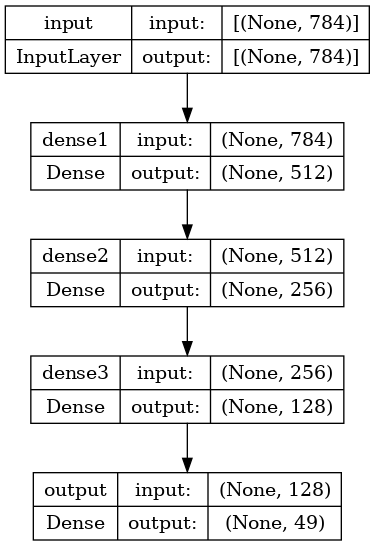

In [30]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [31]:
logdir = os.path.join('logs/kuzushiji-49/', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [32]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(logdir, save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logdir, update_freq=10)
]

In [ ]:
# compile the model, make sure to add accuracy metric

In [33]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', ])

In [ ]:
# train the model, make sure to use callbacks and validation dataset

In [34]:
model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=callbacks, class_weight=class_weights)

Epoch 1/2
6350/6350 [==============================] - 57s 8ms/step - loss: 0.8418 - accuracy: 0.7727 - val_loss: 0.5658 - val_accuracy: 0.8453
Epoch 2/2
6350/6350 [==============================] - 45s 7ms/step - loss: 0.4481 - accuracy: 0.8717 - val_loss: 0.4759 - val_accuracy: 0.8717


In [35]:
images = X_test.reshape(-1, 28, 28, 1) / 255 # normalize if needed

1/1 [==============================] - 0s 95ms/step


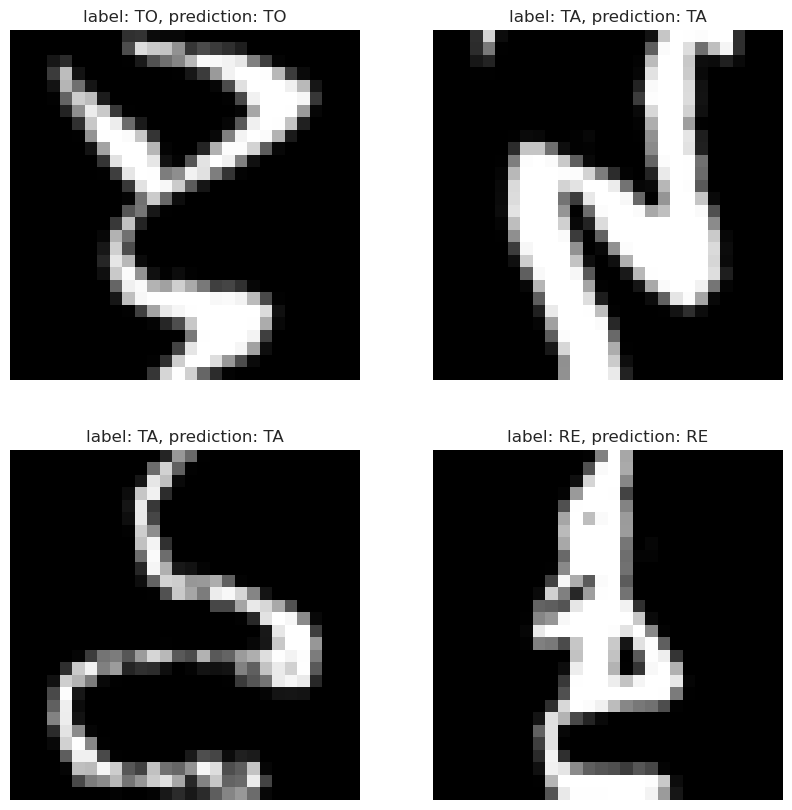

In [36]:
plot_grid_and_label(images, y_test, model, label_description=label_description)

In [38]:
y_pred = model.predict(X_test / 255, verbose=False).argmax(axis=-1) # make predictions

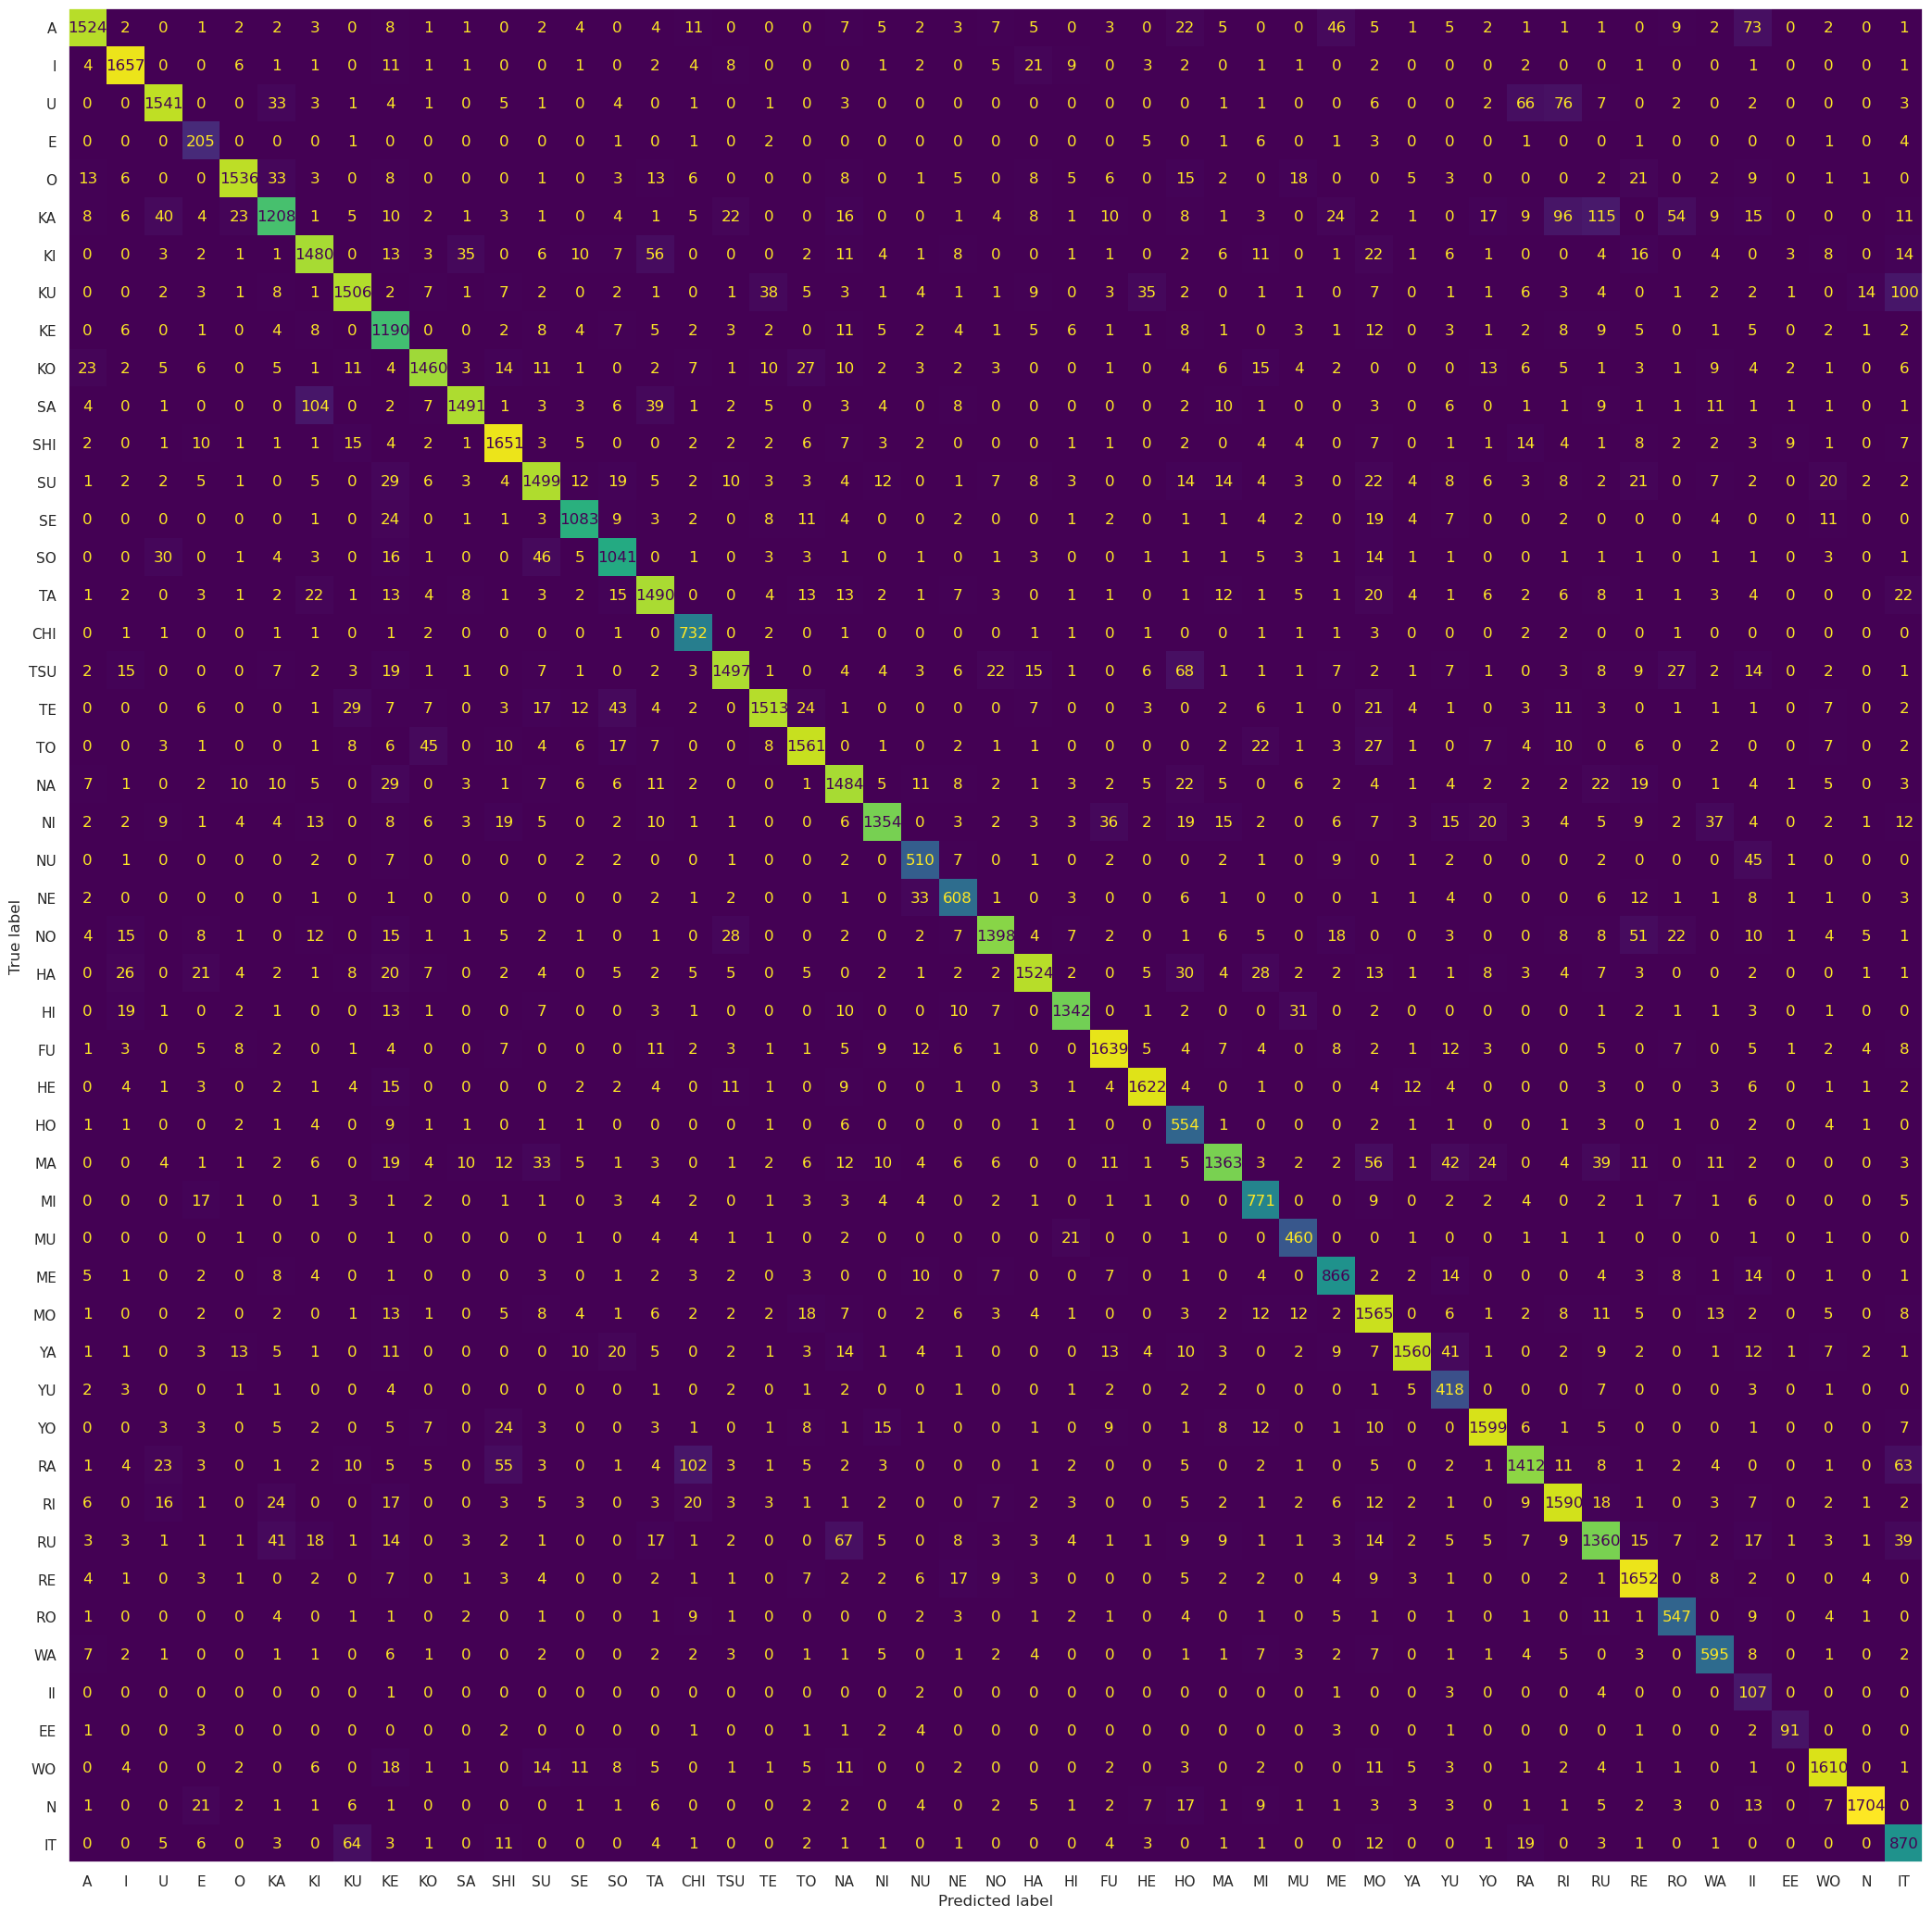

In [39]:
_, ax = plt.subplots(figsize=(26, 26))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [40]:
accuracy = y_test == y_pred
np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])

0.8743496921305374

## Actual images
Use Conv2D layers with Dense layer on top

In [ ]:
# create train and validation datasets, these datasets should use 28x28x1 images

In [41]:
train_data = tf.data.Dataset.from_tensor_slices(X_train).map(lambda x: tf.cast(tf.reshape(x, (28, 28, 1)) / 255, tf.float32))
train_labels = tf.data.Dataset.from_tensor_slices(y_train)
train_dataset = tf.data.Dataset.zip((train_data, train_labels)).batch(32)

val_data = tf.data.Dataset.from_tensor_slices(X_test).map(lambda x: tf.cast(tf.reshape(x, (28, 28, 1)) / 255, tf.float32))
val_labels = tf.data.Dataset.from_tensor_slices(y_test)
val_dataset = tf.data.Dataset.zip((val_data, val_labels)).batch(32)

In [ ]:
# create model, this model should accept a 28x28x1 image

In [42]:
inputs = tf.keras.layers.Input((28, 28, 1), name='input')
x = tf.keras.layers.Conv2D(8,  3, activation='relu', name='conv1')(inputs)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', name='conv2')(x)
x = tf.keras.layers.Conv2D(32, 3, activation='relu', name='conv3')(x)
x = tf.keras.layers.Flatten(name='flatten')(x)
x = tf.keras.layers.Dense(49,  activation='softmax', name='output')(x)
model = tf.keras.Model(inputs=inputs, outputs=x, name='crazyhead')

In [43]:
model.summary()

Model: "crazyhead"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 28, 28, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 26, 26, 8)         80        
                                                                 
 conv2 (Conv2D)              (None, 24, 24, 32)        2336      
                                                                 
 conv3 (Conv2D)              (None, 22, 22, 32)        9248      
                                                                 
 flatten (Flatten)           (None, 15488)             0         
                                                                 
 output (Dense)              (None, 49)                758961    
                                                                 
Total params: 770,625
Trainable params: 770,625
Non-train

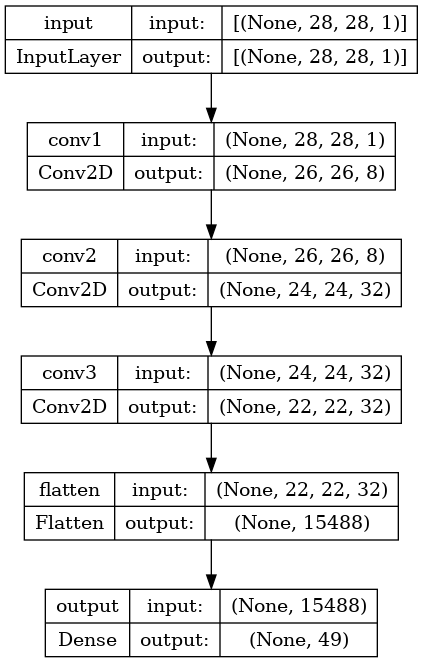

In [44]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [45]:
logdir = os.path.join('logs/kuzushiji-49/', datetime.datetime.now().strftime('%Y%m%d-%H%M%S'))

In [46]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(logdir, save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.TensorBoard(logdir, update_freq=10)
]

In [ ]:
# compile the model, make sure to add accuracy metric

In [47]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy', ])

In [ ]:
# train the model, make sure to use callbacks and validation dataset

In [48]:
model.fit(train_dataset, validation_data=val_dataset, epochs=2, callbacks=callbacks, class_weight=class_weights)

Epoch 1/2
6350/6350 [==============================] - 59s 8ms/step - loss: 0.5405 - accuracy: 0.8599 - val_loss: 0.3175 - val_accuracy: 0.9157
Epoch 2/2
6350/6350 [==============================] - 49s 8ms/step - loss: 0.2273 - accuracy: 0.9345 - val_loss: 0.2872 - val_accuracy: 0.9255


In [49]:
images = X_test.reshape(-1, 28, 28, 1) # normalize if needed

1/1 [==============================] - 0s 104ms/step


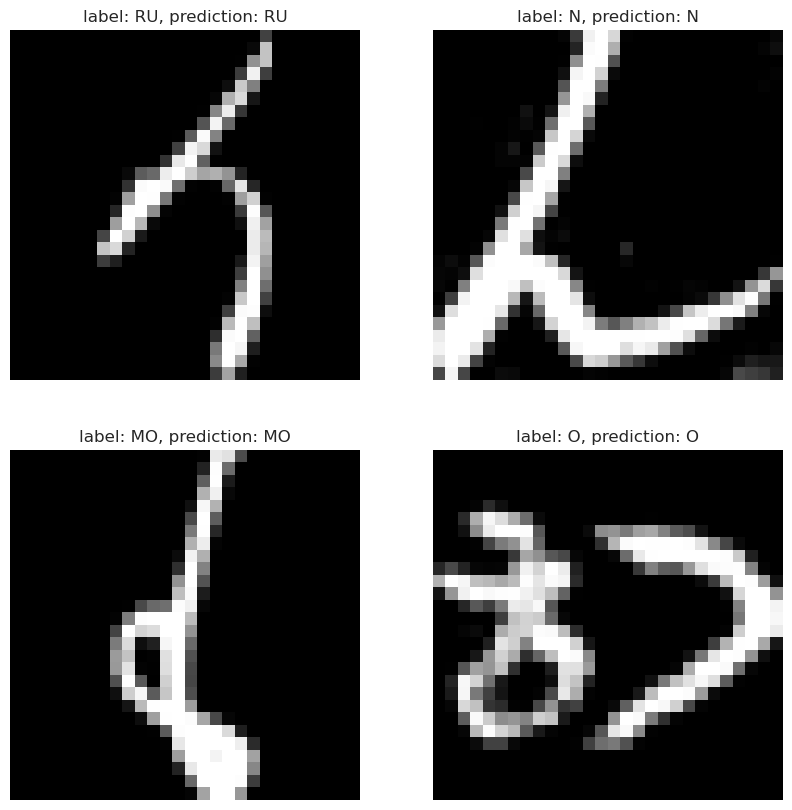

In [50]:
plot_grid_and_label(images, y_test, model, label_description=label_description, flatten_image=False)

In [51]:
y_pred = model.predict(X_test.reshape(-1, 28, 28, 1) / 255, verbose=False).argmax(axis=-1) # make predictions

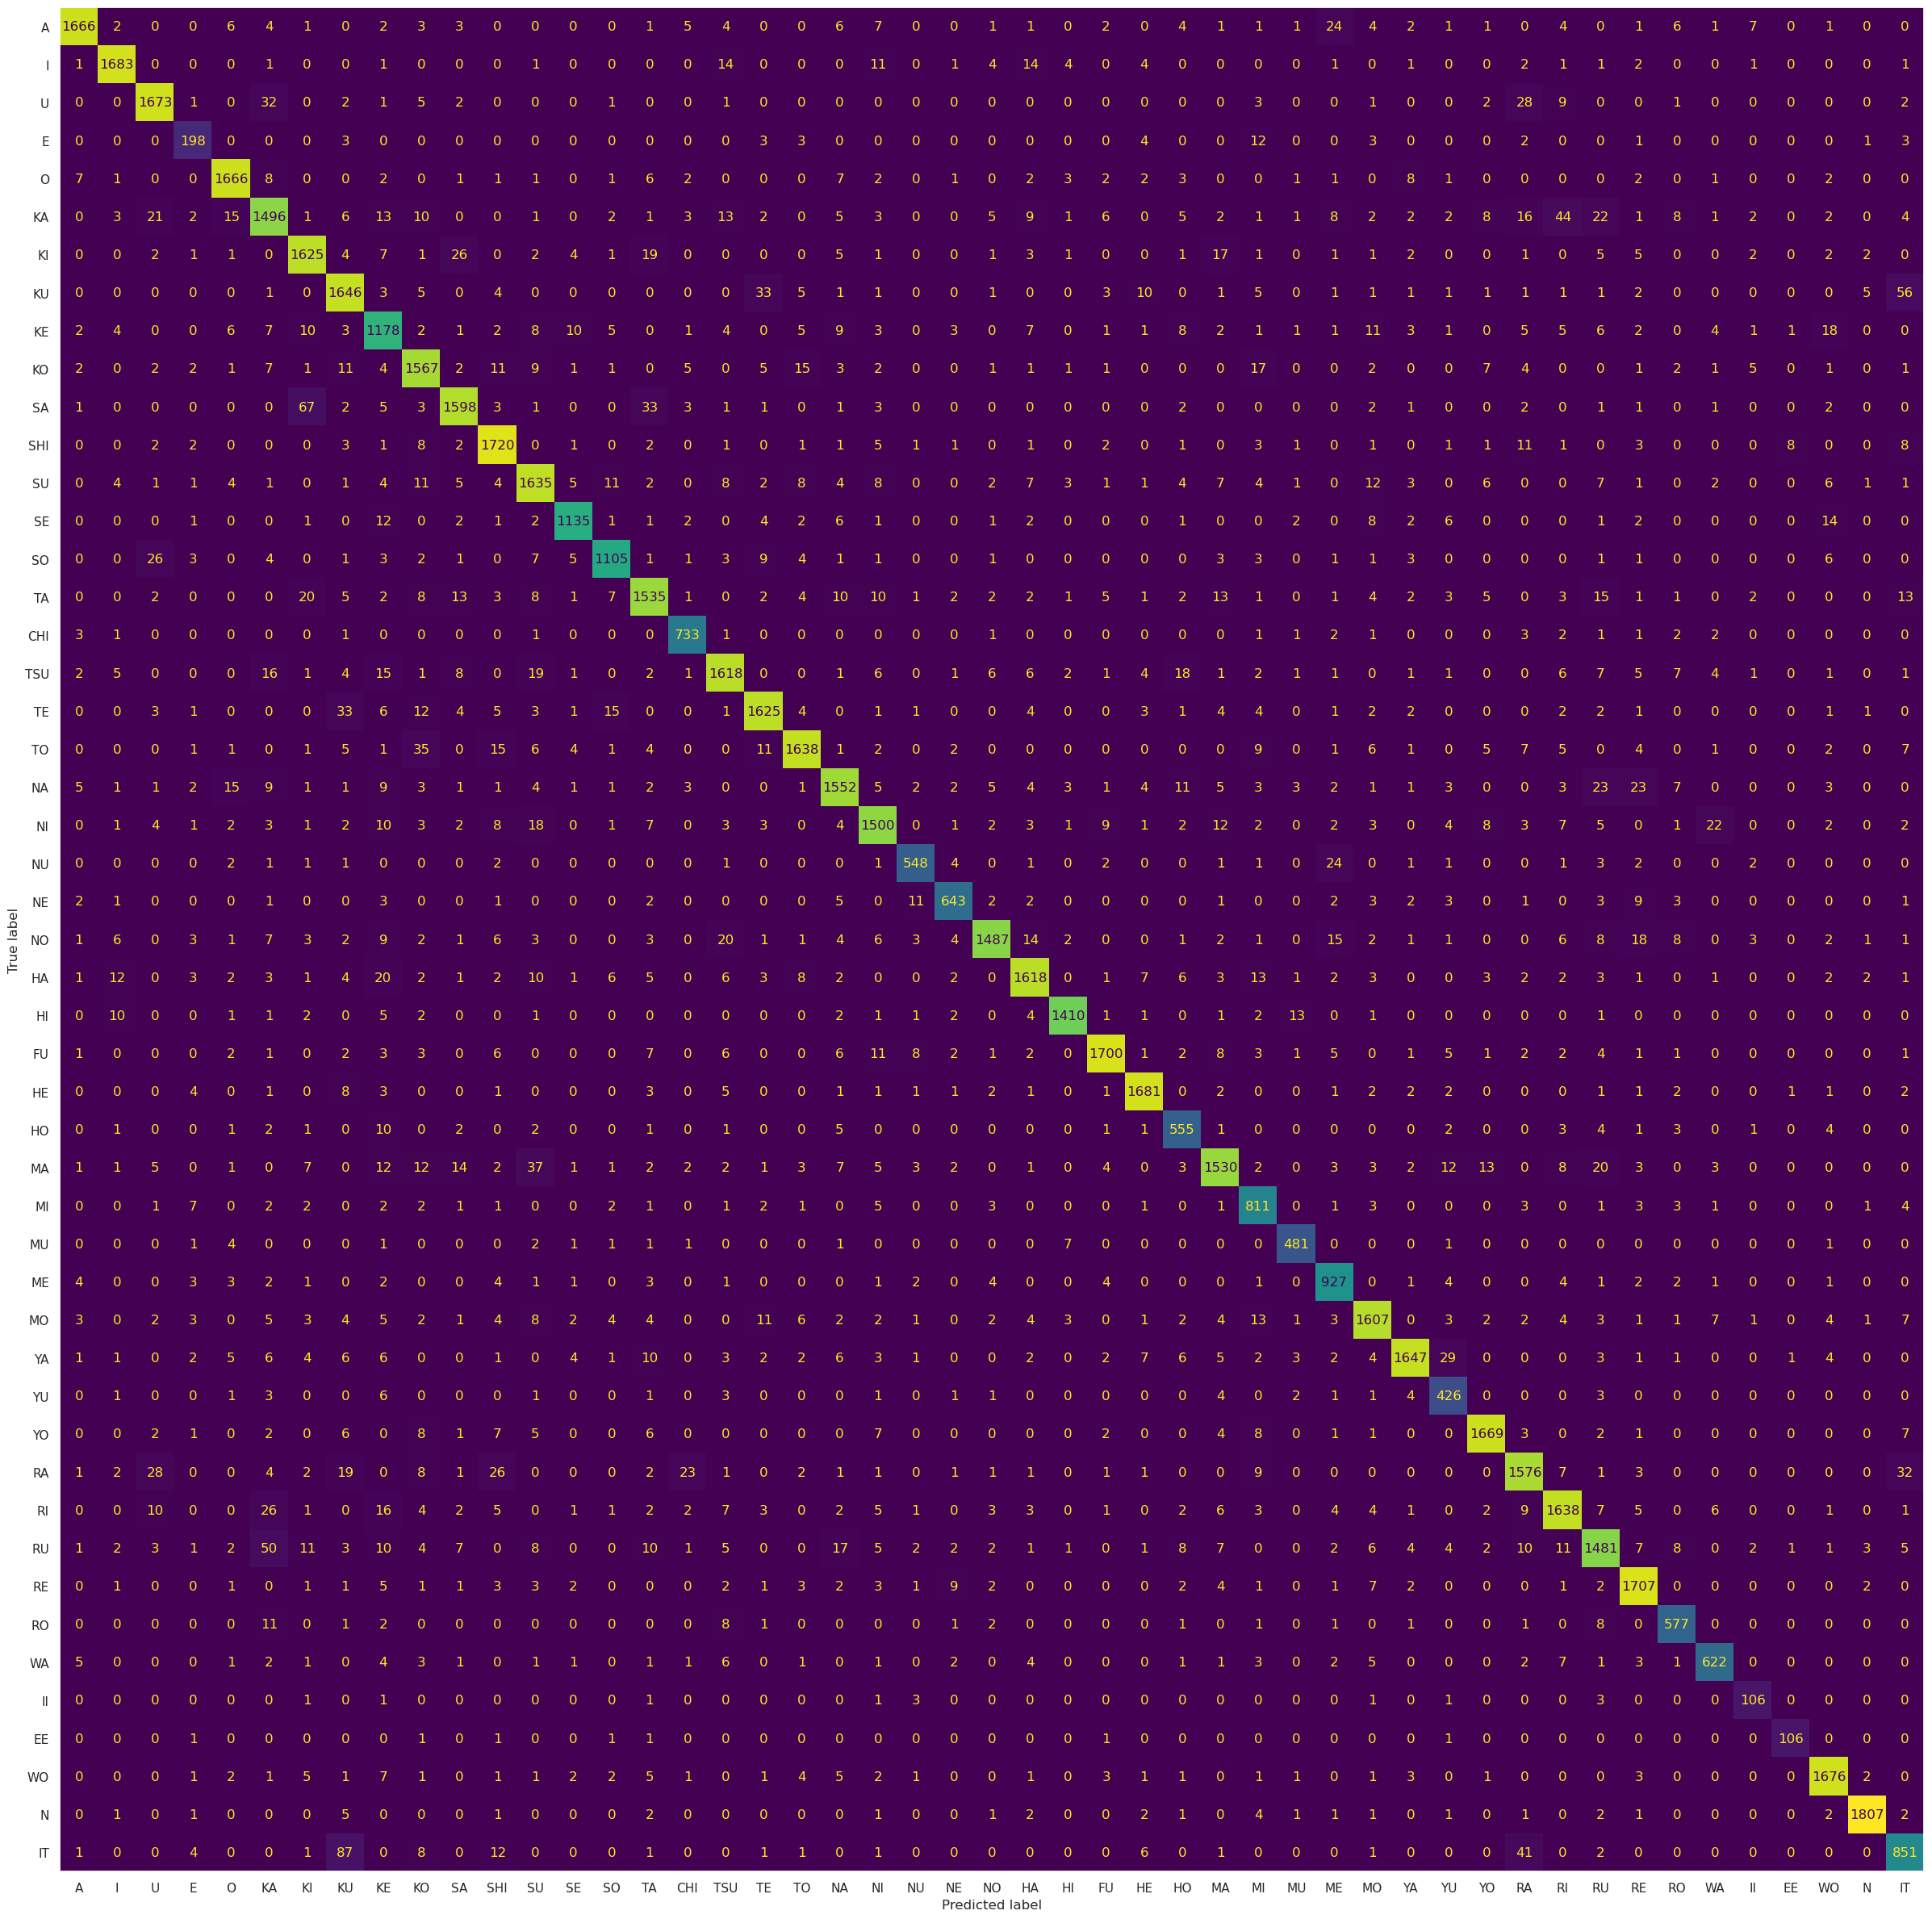

In [52]:
_, ax = plt.subplots(figsize=(30, 30))
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=label_description, ax=ax, colorbar=False)

##### Balanced accuracy

In [63]:
accuracy = y_test == y_pred
np.mean([np.mean(accuracy[y_test == i]) for i in range(49)])



0.9237682572861297